In [23]:
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import (Activation, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers import InstanceNormalization

import tensorflow_datasets as tfds

%matplotlib inline

In [24]:
generator_g_import = tf.keras.models.load_model('generator_g.h5')
generator_f_import = tf.keras.models.load_model('generator_f.h5')
discriminator_x_import = tf.keras.models.load_model('discriminator_x.h5')
discriminator_y_import = tf.keras.models.load_model('discriminator_y.h5')


In [25]:
# Load dataset
data, metadata = tfds.load('cycle_gan/monet2photo', with_info=True, as_supervised=True)

train_x, train_y, test_x, test_y = data['trainA'], data['trainB'], data['testA'], data['testB']

In [26]:
# Settings
epochs = 50

LAMBDA = 10

img_rows, img_cols, channels = 256, 256, 3
weight_initializer = RandomNormal(stddev=0.02)

gen_g_optimizer = gen_f_optimizer = Adam(lr=0.0002, beta_1=0.5)
dis_x_optimizer = dis_y_optimizer = Adam(lr=0.0002, beta_1=0.5)

/Users/billyluqiu/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
# Normalize images to [-1, 1] and reshape
def preprocess_image(image, _):
    return tf.reshape(tf.cast(tf.image.resize(image, (int(img_rows), int(img_cols))), tf.float32) / 127.5 - 1, (1, img_rows, img_cols, channels))

In [28]:
# Map the normalization onto the dataset
train_x = train_x.map(preprocess_image)
train_y = train_y.map(preprocess_image)
test_x = test_x.map(preprocess_image)
test_y = test_y.map(preprocess_image)

In [29]:
test_x

<MapDataset shapes: (1, 256, 256, 3), types: tf.float32>

In [30]:
def generate_images():
    # Sample images
    print(test_x)
    x = next(iter(test_x.shuffle(1000))).numpy()
    y = next(iter(test_y.shuffle(1000))).numpy()
    print(x)
    # Get predictions for those images
    y_hat = generator_g_import.predict(x.reshape((1, img_rows, img_cols, channels)))
    x_hat = generator_f_import.predict(y.reshape((1, img_rows, img_cols, channels)))
    


#BELOW THIS IS THE TEST DATA FROM KAGGLE

In [31]:
images = tf.keras.utils.image_dataset_from_directory(
  "/Users/billyluqiu/Desktop/fall2022/ece588Final/billy/images", batch_size=1)

Found 300 files belonging to 1 classes.


In [32]:
images2 = tf.keras.utils.image_dataset_from_directory(
  "/Users/billyluqiu/Desktop/fall2022/ece588Final/billy/images2", batch_size=1)

Found 7038 files belonging to 1 classes.


In [33]:
test_y = images.map(preprocess_image)

In [34]:
test_x = images2.map(preprocess_image)

In [35]:
test_x

<MapDataset shapes: (1, 256, 256, 3), types: tf.float32>

In [54]:
gen_g_optimizer = gen_f_optimizer = Adam(lr=0.0002, beta_1=0.5)
dis_x_optimizer = dis_y_optimizer = Adam(lr=0.0002, beta_1=0.5)

/Users/billyluqiu/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [82]:
 # Losses
loss = BinaryCrossentropy(from_logits=True)

# Measures how close to one real images are rated, and how close to zero fake images are rated
def discriminator_loss(real, generated):
    # Multiplied by 0.5 so that it will train at half-speed
    return (loss(tf.ones_like(real), real) + loss(tf.zeros_like(generated), generated)) * 0.5

# Measures how real the discriminator believes the fake image is
def gen_loss(validity):
    return loss(tf.ones_like(validity), validity)

# Measures similarity of two images.  Used for cycle and identity loss
def image_similarity(image1, image2):
    return tf.reduce_mean(tf.abs(image1 - image2))

In [83]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [84]:
mse_generated = []
mse_original = []

In [85]:
generator_f_import.compile(gen_f_optimizer, generator_loss)

In [86]:
loss_arr = []

In [87]:
i = 1
for x in test_x:
    x_numpy = x.numpy().reshape((1, img_rows, img_cols, channels))
    y_hat = generator_f_import.predict(x_numpy)
    x_hat = generator_g_import.predict(y_hat)
    loss, acc = generator_f_import.evaluate(x_numpy, y_hat)
    loss_arr.append(loss)
    break
    # normalizedData = (y_hat[0]-np.min(y_hat[0]))/(np.max(y_hat[0])-np.min(y_hat[0]))

    #matplotlib.image.imsave('test_images/'+ str(i) + '.png', normalizedData)

    mse_generated.append(np.mean((y_hat[0] - x_hat[0])**2))
    mse_original.append(np.mean((x_numpy[0] - x_hat[0])**2))

    i += 1

    if i % 500 == 0:
        print(i)
        break
    

2022-12-04 12:47:58.759979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


TypeError: in user code:

    File "/Users/billyluqiu/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 1366, in test_function  *
        return step_function(self, iterator)

    TypeError: tf__generator_loss() takes 1 positional argument but 2 were given


In [50]:
mse_generated

[0.1918379,
 0.08098396,
 0.008003573,
 0.19106005,
 0.041483726,
 0.00408264,
 0.010244875,
 0.00543094,
 0.054560483,
 0.0031840252,
 0.002741433,
 0.0051574497,
 0.0067718825,
 0.03314799,
 0.1970693,
 0.012932452,
 0.0023007528,
 0.12739904,
 0.11794257,
 0.16828424,
 0.011602341,
 0.0027471727,
 0.12687859,
 0.046193898,
 0.0039617363,
 0.13887095,
 0.21197003,
 0.1980151,
 0.003734435,
 0.14060457,
 0.015147518,
 0.004062586,
 0.026681326,
 0.18611683,
 0.21460311,
 0.003949294,
 0.20130378,
 0.19986929,
 0.20586963,
 0.19279419,
 0.20566566,
 0.0031631363,
 0.021363804,
 0.17827313,
 0.009771048,
 0.0022726974,
 0.010081521,
 0.004510397,
 0.17493738,
 0.009489584,
 0.15632261,
 0.15676476,
 0.17300843,
 0.0020959063,
 0.16653179,
 0.065373324,
 0.116181485,
 0.010255174,
 0.028394423,
 0.0022810863,
 0.0055262386,
 0.003092631,
 0.0037504097,
 0.19844878,
 0.014200155,
 0.18019708,
 0.0054677376,
 0.1270824,
 0.21276693,
 0.172561,
 0.046776634,
 0.0037158926,
 0.0039986013,
 0

In [46]:
np.mean((x_numpy[0] - x_hat[0])**2)

0.02586645

(array([5.753e+03, 1.225e+03, 5.200e+01, 2.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.00158216, 0.02318895, 0.04479573, 0.06640252, 0.08800931,
        0.10961609, 0.13122287, 0.15282966, 0.17443644, 0.19604322,
        0.21765001], dtype=float32),
 <BarContainer object of 10 artists>)

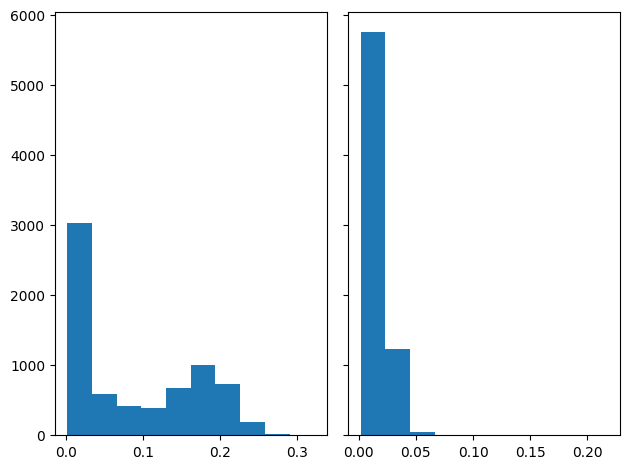

In [51]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(mse_generated)
axs[1].hist(mse_original)